<a href="https://colab.research.google.com/github/Lucs1590/strava-analysis/blob/main/strava_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strava Analysis
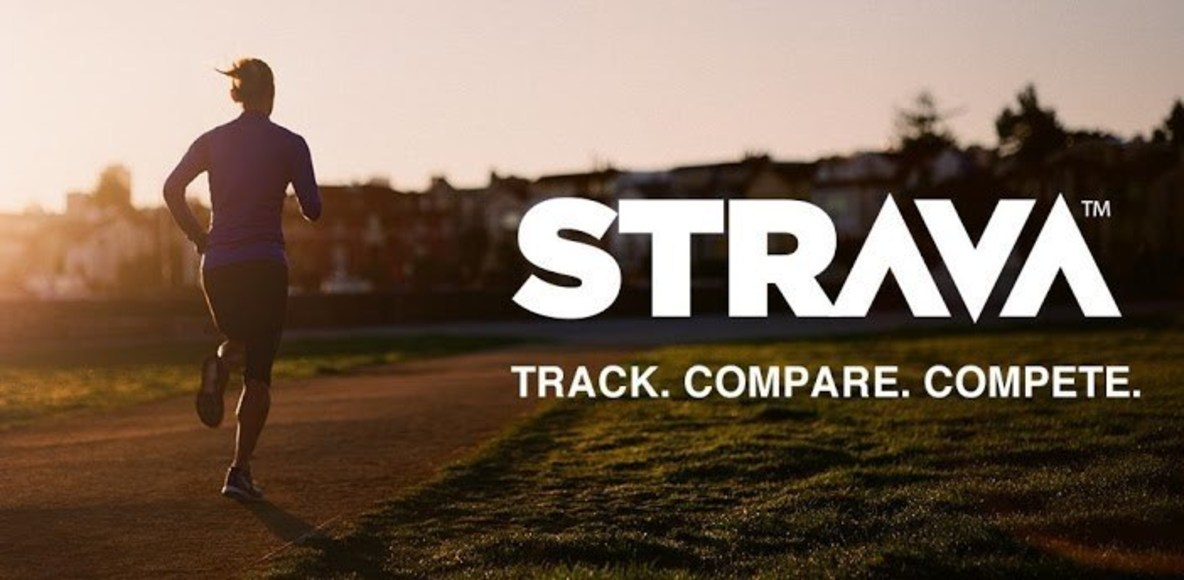
This notebook aims to make a data exploration searching by a pattern on user data and, after, try to predict the pace based on a distance and elevation.


## Imports

In [1]:
# general
import subprocess

# df and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# machine learning and math
import math
from sklearn.feature_selection import mutual_info_classif

## Getting data and first contact

In [2]:
pd.set_option('display.max_columns', None)
%matplotlib widget
%matplotlib inline

In [3]:
subprocess.call('python3 get_activities.py', shell=True)

0

In [4]:
df = pd.read_csv('result/strava_all_activities.csv')

In [5]:
df.head()

,Unnamed: 0,Unnamed: 0.1,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,type,workout_type,id,start_date,start_date_local,timezone,utc_offset,location_city,location_state,location_country,achievement_count,kudos_count,comment_count,athlete_count,photo_count,trainer,commute,manual,private,visibility,flagged,gear_id,start_latlng,end_latlng,average_speed,max_speed,average_cadence,has_heartrate,average_heartrate,max_heartrate,heartrate_opt_out,display_hide_heartrate_option,elev_high,elev_low,upload_id,upload_id_str,external_id,from_accepted_tag,pr_count,total_photo_count,has_kudoed,athlete.id,athlete.resource_state,map.id,map.summary_polyline,map.resource_state,average_watts,kilojoules,device_watts
0,0,0,2,Corrida ao entardecer,5068.3,1642,1648,25.3,Run,NaN,6964268477,2022-04-08T21:36:00Z,2022-04-08T18:36:00Z,(GMT-03:00) America/Sao_Paulo,-10800.0,NaN,NaN,Brasil,0,2,0,2,0,False,False,False,False,everyone,False,g7550415,"[-22.103895, -50.178364]","[-22.102943, -50.181545]",3.087,4.412,81.6,True,160.8,175.0,False,True,597.1,587.8,7.411248e+09,7.411248e+09,shealth3f834ce6-90bc-4761-8414-0b00a62164c7.tcx,False,0,0,False,47005114,1,a6964268477,jd|eCxmgqHhA}BFWh@mAVa@HUJMJ[R[l@yAp@sAVs@l@eA...,2,NaN,NaN,NaN
1,1,1,2,Corrida matinal,7584.5,2366,2554,60.7,Run,NaN,6944788865,2022-04-07T09:48:31Z,2022-04-07T06:48:31Z,(GMT-03:00) America/Sao_Paulo,-10800.0,NaN,NaN,Brasil,2,3,1,1,0,False,False,False,False,everyone,False,g7550415,"[-22.102282, -50.18689]","[-22.102678, -50.1831]",3.206,5.769,83.0,True,170.3,178.0,False,True,611.5,591.2,7.390139e+09,7.390139e+09,shealth1fb9f387-da99-4ca9-86e2-d423ca8ac6b7.tcx,False,0,0,False,47005114,1,a6944788865,hz{eC`ciqHGLHPBNJEK@IN?DJ^B`ALdAHVj@|CRlBV|Al@...,2,NaN,NaN,NaN
2,2,2,2,Corrida ao entardecer,8116.3,2449,2452,53.6,Run,NaN,6932704633,2022-04-04T21:14:18Z,2022-04-04T18:14:18Z,(GMT-03:00) America/Sao_Paulo,-10800.0,NaN,NaN,Brasil,1,6,0,1,0,False,False,False,False,everyone,False,g7550415,"[-22.101946, -50.18041]","[-22.105011, -50.176407]",3.314,5.081,82.9,True,171.6,181.0,False,True,607.3,587.8,7.377123e+09,7.377123e+09,shealth9e77abcb-c74a-448f-8abc-4d747e15c242.tcx,False,0,0,False,47005114,1,a6932704633,jx{eCrzgqHPDf@?f@DXAd@DDC@i@?g@B_@N_@BMHwBRc@b...,2,NaN,NaN,NaN
3,3,3,2,Esteira,5900.0,1800,1800,0.0,Run,3.0,6913625551,2022-03-31T22:33:08Z,2022-03-31T19:33:08Z,(GMT-03:00) America/Sao_Paulo,-10800.0,NaN,NaN,Brasil,0,3,0,1,0,False,False,True,False,everyone,False,g7550415,[],[],3.278,0.000,NaN,False,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,False,0,1,False,47005114,1,a6913625551,NaN,2,NaN,NaN,NaN
4,4,4,2,Corrida ao entardecer,4997.4,1473,1503,20.1,Run,NaN,6904475597,2022-03-29T21:52:37Z,2022-03-29T18:52:37Z,(GMT-03:00) America/Sao_Paulo,-10800.0,NaN,NaN,Brasil,0,3,0,1,0,False,False,False,False,everyone,False,g7550415,"[-22.103828, -50.17825]","[-22.105026, -50.176334]",3.393,5.497,81.4,True,171.7,184.0,False,True,604.0,592.5,7.346453e+09,7.346453e+09,shealthb616f239-257d-498c-ac91-f80d8203ef14.tcx,False,0,0,False,47005114,1,a6904475597,|c|eC`mgqHz@aB~@aBJ[NSL[Xa@v@cBj@qAbAiB~@yBLSd...,2,NaN,NaN,NaN


In [6]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'resource_state', 'name', 'distance',
       'moving_time', 'elapsed_time', 'total_elevation_gain', 'type',
       'workout_type', 'id', 'start_date', 'start_date_local', 'timezone',
       'utc_offset', 'location_city', 'location_state', 'location_country',
       'achievement_count', 'kudos_count', 'comment_count', 'athlete_count',
       'photo_count', 'trainer', 'commute', 'manual', 'private', 'visibility',
       'flagged', 'gear_id', 'start_latlng', 'end_latlng', 'average_speed',
       'max_speed', 'average_cadence', 'has_heartrate', 'average_heartrate',
       'max_heartrate', 'heartrate_opt_out', 'display_hide_heartrate_option',
       'elev_high', 'elev_low', 'upload_id', 'upload_id_str', 'external_id',
       'from_accepted_tag', 'pr_count', 'total_photo_count', 'has_kudoed',
       'athlete.id', 'athlete.resource_state', 'map.id',
       'map.summary_polyline', 'map.resource_state', 'average_watts',
       'kilojoules', 'device_watts'],


In [7]:
df.shape

(227, 57)

In [8]:
df.isnull().sum().sum()

1989

In [9]:
null_df = [[col, df[col].isnull().sum()] for col in df.columns]
list(filter(lambda x: x[1]>0, null_df))

[['workout_type', 100],
 ['location_city', 227],
 ['location_state', 227],
 ['location_country', 3],
 ['gear_id', 86],
 ['average_cadence', 95],
 ['average_heartrate', 160],
 ['max_heartrate', 160],
 ['elev_high', 45],
 ['elev_low', 45],
 ['upload_id', 41],
 ['upload_id_str', 41],
 ['external_id', 89],
 ['map.summary_polyline', 48],
 ['average_watts', 208],
 ['kilojoules', 208],
 ['device_watts', 206]]

## Data manipulation

In [10]:
raw_df = df

In [11]:
selected_columns = ['id','name', 'distance', 'moving_time', 'total_elevation_gain', 'type',
                    'start_date_local', 'athlete_count','average_speed', 'max_speed',
                    'average_cadence', 'average_heartrate','elev_high', 'elev_low', 'pr_count',
                    'average_watts', 'kilojoules', 'device_watts']

In [12]:
df = df[selected_columns]
df.head()

,id,name,distance,moving_time,total_elevation_gain,type,start_date_local,athlete_count,average_speed,max_speed,average_cadence,average_heartrate,elev_high,elev_low,pr_count,average_watts,kilojoules,device_watts
0,6964268477,Corrida ao entardecer,5068.3,1642,25.3,Run,2022-04-08T18:36:00Z,2,3.087,4.412,81.6,160.8,597.1,587.8,0,NaN,NaN,NaN
1,6944788865,Corrida matinal,7584.5,2366,60.7,Run,2022-04-07T06:48:31Z,1,3.206,5.769,83.0,170.3,611.5,591.2,0,NaN,NaN,NaN
2,6932704633,Corrida ao entardecer,8116.3,2449,53.6,Run,2022-04-04T18:14:18Z,1,3.314,5.081,82.9,171.6,607.3,587.8,0,NaN,NaN,NaN
3,6913625551,Esteira,5900.0,1800,0.0,Run,2022-03-31T19:33:08Z,1,3.278,0.000,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
4,6904475597,Corrida ao entardecer,4997.4,1473,20.1,Run,2022-03-29T18:52:37Z,1,3.393,5.497,81.4,171.7,604.0,592.5,0,NaN,NaN,NaN


In [13]:
df['start_date_local'] = pd.to_datetime(df['start_date_local'], errors='coerce')

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_4957/4095640816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_date_local'] = pd.to_datetime(df['start_date_local'], errors='coerce')


In [14]:
df = df.sort_values(by='start_date_local')

In [15]:
df['start_time'] = df['start_date_local'].dt.time
df['start_date'] = df['start_date_local'].dt.date

In [16]:
df = df.drop('start_date_local', 1)
df.head()

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_4957/2372681409.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('start_date_local', 1)


,id,name,distance,moving_time,total_elevation_gain,type,athlete_count,average_speed,max_speed,average_cadence,average_heartrate,elev_high,elev_low,pr_count,average_watts,kilojoules,device_watts,start_time,start_date
226,2753119647,Evening Ride,1585.6,345,10.3,Ride,1,4.596,8.9,NaN,NaN,606.2,596.4,0,NaN,NaN,False,20:09:18,2019-09-30
225,2753195842,Evening Run,1556.1,477,26.0,Run,1,3.262,3.6,NaN,NaN,602.6,589.4,0,NaN,NaN,NaN,20:33:06,2019-09-30
224,2753233770,Night Ride,225.4,61,0.0,Ride,1,3.695,7.1,NaN,NaN,607.3,599.1,0,NaN,NaN,False,21:15:01,2019-09-30
223,2755746533,Evening Ride,203.7,62,0.0,Ride,1,3.285,7.7,NaN,NaN,599.0,596.8,0,28.3,1.8,False,20:08:30,2019-10-01
222,2755853084,Night Ride,192.9,61,0.0,Ride,1,3.162,6.2,NaN,NaN,607.1,599.2,0,69.3,4.2,False,21:02:29,2019-10-01


In [17]:
df = df.drop(df[df.average_speed > 30].index)
df = df.reset_index(drop=True)

## Visualization

Text(0.5, 1.0, 'Exercices')

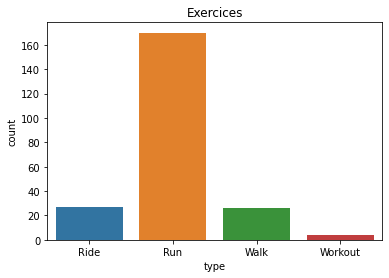

In [18]:
fig = sns.countplot(x='type', data=df).set_title('Exercices')
fig

In [19]:
df['year']= df['start_date'].map(lambda x: x.year)

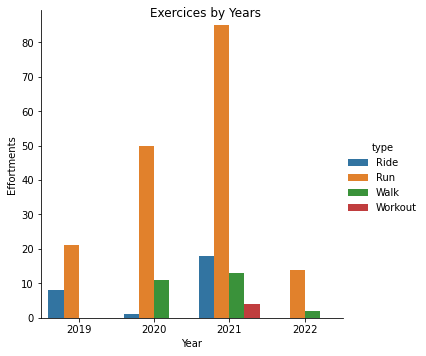

In [20]:
fig = sns.catplot(x='year', hue='type', data=df, kind='count')
fig.fig.suptitle('Exercices by Years')
fig.set_xlabels('Year')
fig.set_ylabels('Effortments')
fig

## Running Analysis

In [21]:
runs = df.loc[df['type'] == 'Run']
runs

,id,name,distance,moving_time,total_elevation_gain,type,athlete_count,average_speed,max_speed,average_cadence,average_heartrate,elev_high,elev_low,pr_count,average_watts,kilojoules,device_watts,start_time,start_date,year
1,2753195842,Evening Run,1556.1,477,26.0,Run,1,3.262,3.600,NaN,NaN,602.6,589.4,0,NaN,NaN,NaN,20:33:06,2019-09-30,2019
6,2781031587,Night Run,102.0,61,0.0,Run,1,1.672,1.900,NaN,NaN,594.4,589.9,0,NaN,NaN,NaN,21:40:58,2019-10-09,2019
8,2781127867,Evening Ride,2586.9,2756,54.0,Run,1,0.939,3.800,NaN,NaN,597.5,588.2,0,NaN,NaN,NaN,19:06:54,2019-10-11,2019
10,2789528029,Evening Run,2219.2,1068,39.3,Run,2,2.078,3.700,NaN,NaN,597.5,588.8,3,NaN,NaN,NaN,19:50:11,2019-10-14,2019
11,2828174770,Morning Run,4505.2,2092,41.4,Run,2,2.154,3.700,NaN,NaN,618.5,595.9,4,NaN,NaN,NaN,07:15:57,2019-10-30,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,6904475597,Corrida ao entardecer,4997.4,1473,20.1,Run,1,3.393,5.497,81.4,171.7,604.0,592.5,0,NaN,NaN,NaN,18:52:37,2022-03-29,2022
223,6913625551,Esteira,5900.0,1800,0.0,Run,1,3.278,0.000,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,19:33:08,2022-03-31,2022
224,6932704633,Corrida ao entardecer,8116.3,2449,53.6,Run,1,3.314,5.081,82.9,171.6,607.3,587.8,0,NaN,NaN,NaN,18:14:18,2022-04-04,2022
225,6944788865,Corrida matinal,7584.5,2366,60.7,Run,1,3.206,5.769,83.0,170.3,611.5,591.2,0,NaN,NaN,NaN,06:48:31,2022-04-07,2022


In [22]:
runs['elev'] = runs['elev_high'] - runs['elev_low']

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_4957/579056262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs['elev'] = runs['elev_high'] - runs['elev_low']


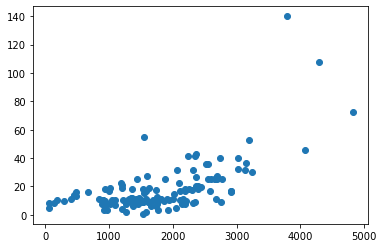

In [24]:
plt.scatter(runs['moving_time'],runs['elev'])
plt.show()

Text(0.5, 1.0, 'All Time vs Elevation')

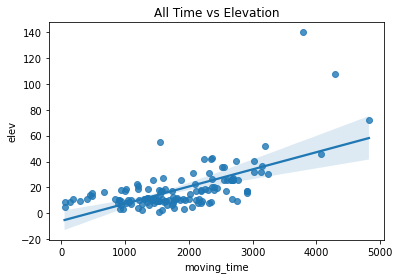

In [35]:
sns.regplot(x='moving_time', y = 'elev', data=runs).set_title("All Time vs Elevation")

Text(0.5, 1.0, 'Average Speed vs Distance')

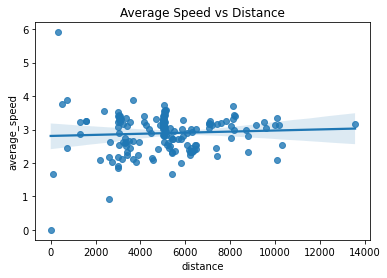

In [25]:
sns.regplot(x='distance', y = 'average_speed', data=runs).set_title("Average Speed vs Distance")

Text(0.5, 1.0, 'Max Speed vs Distance')

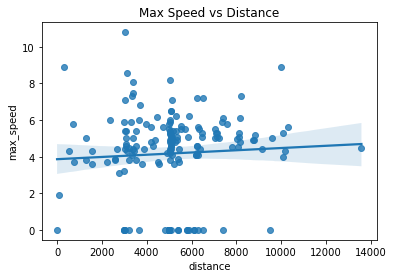

In [26]:
sns.regplot(x='distance', y = 'max_speed', data=runs).set_title("Max Speed vs Distance")

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_4957/3097083979.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


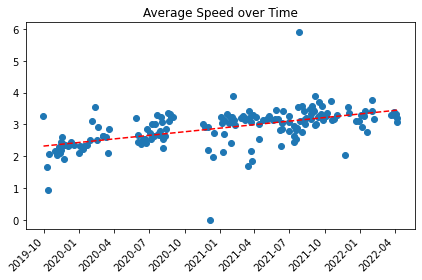

In [27]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.asarray(runs.start_date)
y = np.asarray(runs.average_speed)

ax1.plot_date(x, y)
ax1.set_title('Average Speed over Time')

#add trend line
x2 = mdates.date2num(x)

z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')

fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()

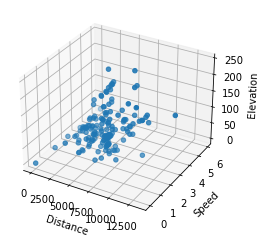

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = runs['distance']
y = runs['average_speed']
z = runs['total_elevation_gain']

ax.set_xlabel("Distance")
ax.set_ylabel("Speed")
ax.set_zlabel("Elevation")

ax.scatter(x, y, z)

plt.show()

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_4957/2795868733.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


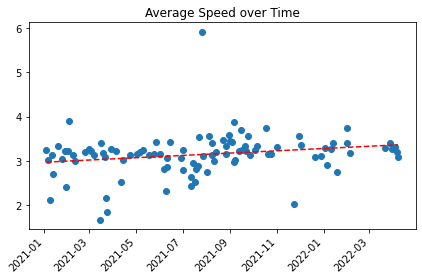

In [29]:
startdate = pd.to_datetime("2021-01-01").date()
recently_runs = runs.loc[runs['start_date'] > startdate]

fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.asarray(recently_runs.start_date)
y = np.asarray(recently_runs.average_speed)

ax1.plot_date(x, y)
ax1.set_title('Average Speed over Time')

#add trend line
x2 = mdates.date2num(x)

z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')

fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()

## Biking Analysis

In [30]:
rides = df.loc[df['type'] == 'Ride']
rides

,id,name,distance,moving_time,total_elevation_gain,type,athlete_count,average_speed,max_speed,average_cadence,average_heartrate,elev_high,elev_low,pr_count,average_watts,kilojoules,device_watts,start_time,start_date,year
0,2753119647,Evening Ride,1585.6,345,10.3,Ride,1,4.596,8.9,NaN,NaN,606.2,596.4,0,NaN,NaN,False,20:09:18,2019-09-30,2019
2,2753233770,Night Ride,225.4,61,0.0,Ride,1,3.695,7.1,NaN,NaN,607.3,599.1,0,NaN,NaN,False,21:15:01,2019-09-30,2019
3,2755746533,Evening Ride,203.7,62,0.0,Ride,1,3.285,7.7,NaN,NaN,599.0,596.8,0,28.3,1.8,False,20:08:30,2019-10-01,2019
4,2755853084,Night Ride,192.9,61,0.0,Ride,1,3.162,6.2,NaN,NaN,607.1,599.2,0,69.3,4.2,False,21:02:29,2019-10-01,2019
5,2776607227,Night Ride,1630.9,373,24.8,Ride,1,4.372,9.6,NaN,NaN,611.2,596.8,0,77.7,29.0,False,21:13:16,2019-10-09,2019
7,2781127862,Evening Ride,1608.2,351,25.0,Ride,1,4.582,7.9,NaN,NaN,611.2,596.8,0,87.2,30.6,False,18:47:12,2019-10-11,2019
9,2781140196,Evening Ride,305.9,88,0.0,Ride,1,3.476,6.6,NaN,NaN,607.0,599.1,0,70.0,6.2,False,19:55:40,2019-10-11,2019
14,2858518319,Evening Ride,1980.0,417,32.1,Ride,1,4.748,10.1,NaN,NaN,611.2,587.4,0,89.8,37.4,False,20:37:02,2019-11-11,2019
30,3002630090,Morning Ride,1544.2,310,15.1,Ride,1,4.981,8.5,NaN,NaN,611.1,596.8,0,76.5,23.7,False,10:39:02,2020-01-11,2020
92,4573720222,Evening Ride,11300.0,1863,0.0,Ride,1,6.065,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,19:21:18,2021-01-05,2021


Text(0.5, 1.0, 'Average Speed vs Distance')

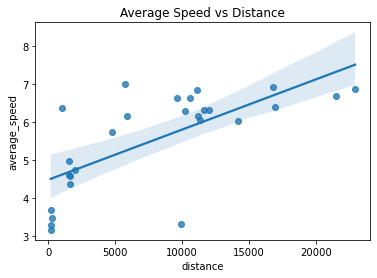

In [31]:
sns.regplot(x='distance', y = 'average_speed', data=rides).set_title("Average Speed vs Distance")

Text(0.5, 1.0, 'Max Speed vs Distance')

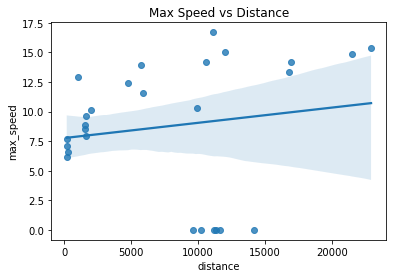

In [32]:
sns.regplot(x='distance', y = 'max_speed', data=rides).set_title("Max Speed vs Distance")

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_4957/2184546799.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


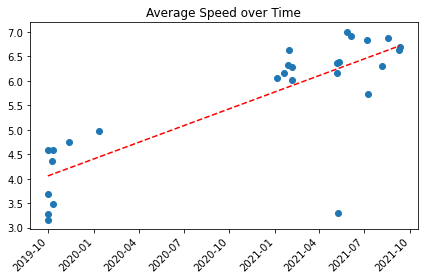

In [33]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.asarray(rides.start_date)
y = np.asarray(rides.average_speed)

ax1.plot_date(x, y)
ax1.set_title('Average Speed over Time')

#add trend line
x2 = mdates.date2num(x)

z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')

fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()

Text(0.5, 1.0, 'Distance vs Elevation Gain')

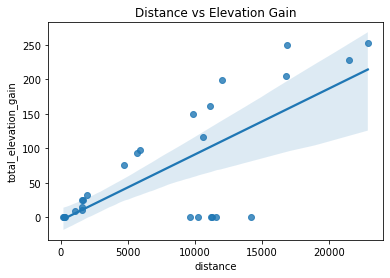

In [34]:
sns.regplot(x='distance', y = 'total_elevation_gain', data = rides ).set_title("Distance vs Elevation Gain")